# "영화는 왜 성공할까? 캐글 영화 데이터로 보는 평점과 흥행의 관계"

## 1. 프로젝트 개요

In [1]:
'''
캐글 영화 데이터를 활용한 분석 프로젝트
목표 : 영화의 평점과 수익간의 관계를 탐색하고 간단한 예측 모델 실험
흥행이 된 영화에는 어떤 특성이 있을까 라는 생각에서 비롯된 프로젝트
'''

'\n캐글 영화 데이터를 활용한 분석 프로젝트\n목표 : 영화의 평점과 수익간의 관계를 탐색하고 간단한 예측 모델 실험\n흥행이 된 영화에는 어떤 특성이 있을까 라는 생각에서 비롯된 프로젝트\n'

## 2. 데이터셋 소개

In [2]:
'''
출처 페이지 : https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/ (Kaggle)
데이터 수 : 1083289

주요 컬럼 :
vote_average : 평점
revenue, budget : 수익, 제작비
genres : 장르

'''

'\n출처 페이지 : https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/ (Kaggle)\n데이터 수 : 1083289\n\n주요 컬럼 :\nvote_average : 평점\nrevenue, budget : 수익, 제작비\ngenres : 장르\n\n\n평점과 수익간의 관계를 파악하기 위해 평점, 수익, 제작비, 장르 컬럼을 사용\n'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 영화 데이터셋 불러오기
df = pd.read_csv("TMDB_movie_dataset_v11.csv")

In [4]:
# 판다스 출력 옵션: 컬럼 많이 보여주기
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 160)

# 사용할 핵심 컬럼이 실제로 데이터셋에 존재하는지 확인
# 이번단계에서 필요한 컬럼 목록
required_cols = ["vote_average", "revenue", "budget", "genres"]

# 원본 df에 없는 컬럼이 있는지 체크
missing = [c for c in required_cols if c not in df.columns]

# 만약 빠진 컬럼이 있다면 지금 바로 알려주고 진행을 멈춤
if missing:
    print("\n[경고] 다음 컬럼이 존재하지 않음:", missing)
    print("→ CSV의 실제 컬럼명을 알려주시면 매핑해서 처리")
else:
    print("\n필요 컬럼이 모두 존재")



필요 컬럼이 모두 존재


## 3. 분석 방향 설정

In [5]:
'''
‘영화의 성공’을 어떻게 정의할까?

평점이 7점 이상일 경우 평범
평점이 7.5점 이상일 경우 성공
평점이 8.0점 이상일 경우 대성공

투표수 문제로 컷오프 :
투표수가 낮음에도 평점이 높은 경우가 있기때문에
4표 이상의 영화로 컷오프
 - 대부분의 영화들이 0~4표(90퍼센트)이기 때문에 유효한 데이터를 얻기 위해 4표로 컷오프

'''

"\n'영화의 성공'을 어떻게 정의할까?\n이 프로젝트 에서는 수익이 제작비보다 많으면 '성공'이라 정의\n -> ROI(Retrun On Investment) > 1\n\n단 영화의 성공에는 제작비, 배우, 홍보 요소등 많은 요소가 있지만 \n이 프로젝트에서는 평점, 수익, 제작비의 데이터만 사용하여 분석함\n"

## 4. 데이터 전처리 개요

In [6]:
'''
대용량 CSV(데이터셋)에는 문자열로 섞인 숫자(ex: '1,000')가 있을수 있음
일괄적으로 깨끗한 숫자(float)로 변환해야함
'''

"\n대용량 CSV(데이터셋)에는 문자열로 섞인 숫자(ex: '1,000')가 있을수 있음\n일괄적으로 깨끗한 숫자(float)로 변환해야함\n"

In [7]:
def to_numeric_safe(x):
    '''
    문자열/숫자 섞인 데이터를 안전하게 숫자형으로 바꾸는 함수.
    숫자로 바꾸지 못할 경우 NaN으로 처리
    '''

    try:
        # 문자열에 콤마가 포함될 수 있어 제거
        if isinstance(x, str):
            x = x.replace(",", "").strip()

        # 숫자로 변환 (실패시 NaN)
        return pd.to_numeric(x, errors = "coerce")
    except Exception:
        return np.nan


# 평점 / 수익 / 제작비 컬럼을 숫자형으로 강제 변환
for col in ["vote_average", "revenue", "budget"]:
    if col in df.columns:
        df[col] = df[col].apply(to_numeric_safe)

# print(df[["vote_average", "revenue", "budget"]].describe())

In [8]:
'''
TDMB 데이터의 genres의 데이터 형태는 아래 중 하나일 수 있음
 - JSON 문자열 : "[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name': 'Action'}]"
 - 콤마로 구분된 단순 문자열: "Drama,Action"
 - 이미 리스트 형태(희소)
따라서 최대한 범용적으로 '장르 이름 리스트'로 변환합니다.
'''

import json

def parse_genres(val):
    '''
    genres 컬럼을 '장르 이름들의 리스트'로 변환
     - JSON 문자열 -> 각 dict의 name만 추출
     - 콤마 구분 문자열 -> 각 토큰을 strip하여 리스트로
     - 이미 리스트 -> 문자열 목록으로 통일
     - 그 외/ 실패 -> 빈 리스트([])
    '''

    # 이미 파싱된 리스트 형태
    if isinstance(val, list):
        names = []
        for item in val:
            if isinstance(item, dict) and "name" in item:
                names.append(str(item["name"]).strip())
            else:
                names.append(str(item).strip())
        return names


    # 문자열인 경우
    if isinstance(val, str):
        s = val.strip()

        # 빈 문자열이나 빈 리스트 일경우 빈 리스트 반환
        if s == "" or s == "[]":
            return []

        # JSON 문자열일 가능성 : 작은 따옴표를 큰 따옴표로 바꿔서 파싱시도
        try:
            maybe_json = s.replace("'", '"')
            obj = json.loads(maybe_json)
            if isinstance(obj, list):
                names = []
                for item in obj:
                    if isinstance(item, dict) and "name" in item:
                        names.append(str(item["name"]).strip())
                    else:
                        names.append(str(item).strip())
                return names
        except Exception:
            pass
            
        if "," in s:
            return [token.strip() for token in s.split(",") if token.strip()]

        # 위 어떤 경우도 아니면 단일 문자열을 리스트로 감싸서 반환
        return [s]

    # 그 외 타입(숫자/NaN 등)은 빈 리스트 처리
    return []

df["genres_parsed"] = df["genres"].apply(parse_genres)
print(df["genres_parsed"])

0                   [Action, Science Fiction, Adventure]
1                    [Adventure, Drama, Science Fiction]
2                       [Drama, Action, Crime, Thriller]
3          [Action, Adventure, Fantasy, Science Fiction]
4                   [Science Fiction, Action, Adventure]
                               ...                      
1266860                                         [Comedy]
1266861                                    [Documentary]
1266862                                    [Documentary]
1266863                         [Documentary, Animation]
1266864                           [Crime, Comedy, Drama]
Name: genres_parsed, Length: 1266865, dtype: object


In [9]:
'''
하나의 영화에는 다양한 장르가 혼합되어 만들어짐
예를 들어 인셉션에는 액션, SF, 어드벤처가 포함되며 특히 드라마, 다큐멘터리 이 장르는 많은 영화에 포함되어 있기때문에
이 두 장르에 대해서는 단일 장르에 대해서만 인정하고 다른 장르안에도 포함되어 있을경우 제외하고 진행함
'''

'\n하나의 영화에는 다양한 장르가 혼합되어 만들어짐\n예를 들어 인셉션에는 액션, SF, 어드벤처가 포함되며 특히 드라마, 다큐멘터리 이 장르는 많은 영화에 포함되어 있기때문에\n이 두 장르에 대해서는 단일 장르에 대해서만 인정하고 다른 장르안에도 포함되어 있을경우 제외하고 진행함\n'

In [10]:
exclude_if_combined = ["Drama", "Documentary"]

def filter_genres(genres_list):
    '''
    장르 리스트에서 드라마와 다큐멘터리는 단일 장르일때만 유지
    다른 장르와 같이 있을경우 제거
    '''

    if not isinstance(genres_list, list):
        return []

    # 장르가 1개뿐이면 그대로 유지
    if len(genres_list) == 1:
        return genres_list

    filtered = [g for g in genres_list if g not in exclude_if_combined]
    return filtered

df["genres_filtered"] = df["genres_parsed"].apply(filter_genres)

# 5. EDA 1 - 평점 분포

In [11]:
'''
우리는 평점을 기준으로 영화의 성공이냐 아니냐를 나눌것이기에 이 평점이 어떻게 분포되어 있는지 알아야함.
그 이유는 어떤 영화는 유명하지 않고 흥행했다고 보기 힘들지만 적은 투표수로 높은 평점을 받았을 수 있으므로 
평점의 분포를 확인하여 일정 투표수 이하는 제외하는것이 필요(컷오프)

이런 컷오프를 하기 위해서는 평점이 어떻게 분포되어있는지 알아야 하기떄문에 이 과정을 거침
'''

'\n우리는 평점을 기준으로 영화의 성공이냐 아니냐를 나눌것이기에 이 평점이 어떻게 분포되어 있는지 알아야함.\n그 이유는 어떤 영화는 유명하지 않고 흥행했다고 보기 힘들지만 적은 투표수로 높은 평점을 받았을 수 있으므로 \n평점의 분포를 확인하여 일정 투표수 이하는 제외하는것이 필요(컷오프)\n\n이런 컷오프를 하기 위해서는 평점이 어떻게 분포되어있는지 알아야 하기떄문에 이 과정을 거침\n'

In [12]:
# 결측 제거
vote_avg_clean = df["vote_average"].dropna()

# 기본 통계

# print("=== 평점 기초 통계 === ")
# print(vote_avg_clean.describe())  # count, mean, std, min, max 등
# print("\n평균 평점:", round(vote_avg_clean.mean(), 2))
# print("중앙값:", round(vote_avg_clean.median(), 2))

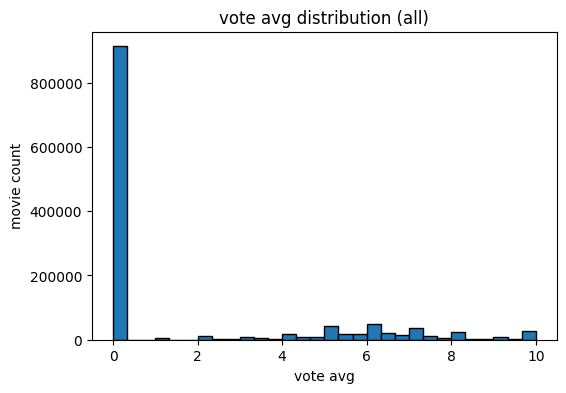

In [13]:
# 히스토그램
plt.figure(figsize=(6,4))
plt.hist(vote_avg_clean, bins=30, edgecolor='black')
plt.title("vote avg distribution (all)")
plt.xlabel("vote avg")
plt.ylabel("movie count")
plt.show()


=== 투표수 기초 통계 ===
count    1.266865e+06
mean     1.693399e+01
std      3.017504e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      3.449500e+04
Name: vote_count, dtype: float64
투표수 ≤ 4 영화 비율: 90.07%


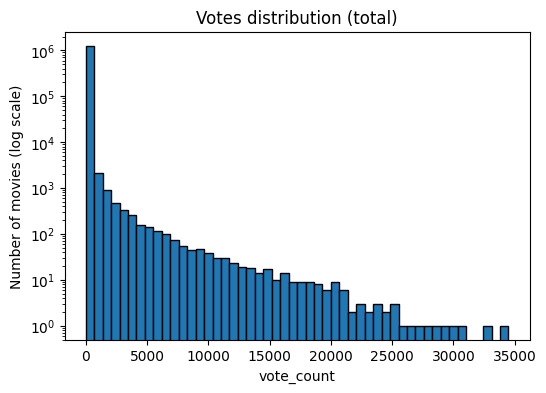

In [14]:
if "vote_count" in df.columns:
    vote_count_clean = df["vote_count"].dropna()
    print("\n=== 투표수 기초 통계 ===")
    print(vote_count_clean.describe())

    # 투표수가 4 이하인 영화 비율
    low_vote_ratio = (vote_count_clean <= 4).mean() * 100
    print(f"투표수 ≤ 4 영화 비율: {low_vote_ratio:.2f}%")

    plt.figure(figsize=(6,4))
    plt.hist(vote_count_clean, bins=50, edgecolor='black')
    plt.yscale("log")  # 투표수 범위가 넓어서 로그축
    plt.title("Votes distribution (total)")
    plt.xlabel("vote_count")
    plt.ylabel("Number of movies (log scale)")
    plt.show()

In [15]:
'''
90퍼센트의 영화는 4표도 받지 못했고, 4표이하의 영화는 평점을 이용하기에는 너무 적기에 컷오프함
'''

'\n90퍼센트의 영화는 4표도 받지 못했고, 4표이하의 영화는 평점을 이용하기에는 너무 적기에 컷오프함\n'


Data size after cutoff application: (146702, 26)
Average score after cutoff application: 5.96


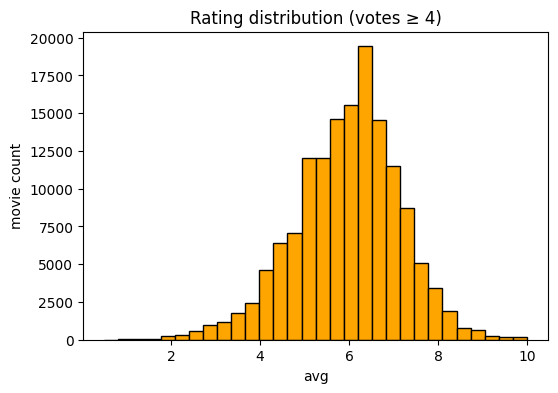

In [16]:
if "vote_count" in df.columns:
    df_cutoff = df[df["vote_count"] >= 4].copy()
    print("\nData size after cutoff application:", df_cutoff.shape)
    
    vote_avg_cutoff = df_cutoff["vote_average"].dropna()
    print("Average score after cutoff application:", round(vote_avg_cutoff.mean(), 2))
    
    plt.figure(figsize=(6,4))
    plt.hist(vote_avg_cutoff, bins=30, edgecolor='black', color='orange')
    plt.title("Rating distribution (votes ≥ 4)")
    plt.xlabel("avg")
    plt.ylabel("movie count")
    plt.show()

In [17]:
'''
컷오프 전보다 데이터 수는 확연히 줄어들었지만 신뢰도있는 평점분포 데이터가 만들어짐
컷오프 전보다 컷오프 후 평균평점이 낮아진것으로 보아 표본이 적은 영화에서 높은 평점이 많았다는 것을 알수있음

평점분포 특징으로는 5~7점구간에 몰려있고 정규분포와 비슷하지만 오른쪽이 약간 길다.

이 데이터를 활용하여 평점을 구간화 하여 장르 분석을 한다면 왜곡될 가능성이 적어질 것으로 보인다.
'''

'\n컷오프 전보다 데이터 수는 확연히 줄어들었지만 신뢰도있는 평점분포 데이터가 만들어짐\n컷오프 전보다 컷오프 후 평균평점이 낮아진것으로 보아 표본이 적은 영화에서 높은 평점이 많았다는 것을 알수있음\n\n평점분포 특징으로는 5~7점구간에 몰려있고 정규분포와 비슷하지만 오른쪽이 약간 길다.\n\n이 데이터를 활용하여 평점을 구간화 하여 장르 분석을 한다면 왜곡될 가능성이 적어질 것으로 보인다.\n'

# 5. EDA 2 - 평점 구간화

In [18]:
'''
영화의 평점을 구간화 하기전에 평범, 성공, 대성공이 어느 기준인지 명확히 해야한다.
그러기 위해서는 특정 평점이 상위 몇% 지점인지 알아야 한다.

따라서 6.5, 7, 7.5, 8점이 상위 몇퍼센트의 평점인지 알아봐야 한다.
'''


'\n영화의 평점을 구간화 하기전에 평범, 성공, 대성공이 어느 기준인지 명확히 해야한다.\n그러기 위해서는 특정 평점이 상위 몇% 지점인지 알아야 한다.\n\n따라서 6.5, 7, 7.5, 8점이 상위 몇퍼센트의 평점인지 알아봐야 한다.\n'

In [19]:
# 컷오프된 데이터셋 (vote_count >= 4)
df_cutoff = df[df["vote_count"] >= 4].copy()

# 평점 7점 이상 비율 계산
high_rating_ratio = (df_cutoff["vote_average"] >= 8.0).mean() * 100

# 평점 7점 이상 영화 개수
high_rating_count = (df_cutoff["vote_average"] >= 8.0).sum()

# 전체 영화 개수
total_movies = len(df_cutoff)

print(f"평점 6.5 이상 영화 개수: {high_rating_count:,}")
print(f"전체 영화 개수: {total_movies:,}")
print(f"평점 6.5 이상 비율: {high_rating_ratio:.2f}%")



평점 6.5 이상 영화 개수: 5,051
전체 영화 개수: 146,702
평점 6.5 이상 비율: 3.44%


In [20]:
'''
위의 과정에서 알 수 있는 것은
6.5점 -> 상위 35%
7.0점 -> 상위 20%
7.5점 -> 상위 8%
8.0점 -> 상위 3.5%
따라서 6.5점부터 7.5점까지 평범, 7.5점부터 8점까지 성공, 8점이상은 대성공이라 정의하고 
평점구간화를 진행
'''

'\n위의 과정에서 알 수 있는 것은\n6.5점 -> 상위 35%\n7.0점 -> 상위 20%\n7.5점 -> 상위 8%\n8.0점 -> 상위 3.5%\n따라서 6.5점부터 7.5점까지 평범, 7.5점부터 8점까지 성공, 8점이상은 대성공이라 정의하고 \n평점구간화를 진행\n'

In [21]:
# 평점 구간화 함수

def categorize_rating_new(v):
    if v >= 8.0:
        return "대성공"
    elif v >= 7.5:
        return "성공"
    elif v >= 6.5:
        return "평범"
    else:
        return "기타"

# 적용
df_cutoff["rating_category"] = df_cutoff["vote_average"].apply(categorize_rating_new)

# 구간별 개수
category_counts = df_cutoff["rating_category"].value_counts().reindex(["기타", "평범", "성공", "대성공"])
category_ratios = (category_counts / len(df_cutoff) * 100).round(2)

print("\n=== 평점 구간별 비율(%) ===")
print(category_ratios)


=== 평점 구간별 비율(%) ===
rating_category
기타     65.11
평범     26.58
성공      4.86
대성공     3.44
Name: count, dtype: float64


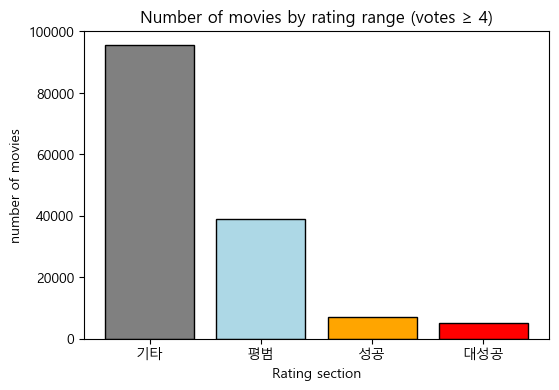

In [22]:
# 시각화
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic')  # Windows: 맑은 고딕
plt.rc('axes', unicode_minus=False) 

plt.figure(figsize=(6,4))
plt.bar(category_counts.index, category_counts.values, color=["gray", "lightblue", "orange", "red"], edgecolor="black")
plt.title("Number of movies by rating range (votes ≥ 4)")
plt.xlabel("Rating section")
plt.ylabel("number of movies")
plt.show()

# 5. EDA 3 - 장르별 분석

In [23]:
'''
EDA 2번까지 내용을 정리하면 아래와 같은 결과가 나온다.
6.5 ~ 7.5점 -> 26.5%
7.5점 ~ 8.0점 -> 4.8%
8.0점 이상 -> 3.4%

그렇다면 이제는 장르별 분석을 통해 어떤 장르의 평점이 높고 낮은지 알아보고,
나아가서 구간별 평점과 전체 영화수와의 비율을 통해 효율이 어떻게 나오는지 분석을 진행한다.
'''

'\nEDA 2번까지 내용을 정리하면 아래와 같은 결과가 나온다.\n6.5 ~ 7.5점 -> 26.5%\n7.5점 ~ 8.0점 -> 4.8%\n8.0점 이상 -> 3.4%\n\n그렇다면 이제는 장르별 분석을 통해 어떤 장르의 평점이 높고 낮은지 알아보고,\n나아가서 구간별 평점과 전체 영화수와의 비율을 통해 효율이 어떻게 나오는지 분석을 진행한다.\n'

## 1. 장르 분리

In [24]:
'''
CSV 데이터 안에는 리스트([])안에 여러 장르가 담겨 있다. 
예를 들면 ["Action", "war"] 이렇게 두개가 들어있을 수 있는데 각각의 데이터를 사용하기 위해서는 장르를 분리하여 만들어줘야 한다.
이 방식을 사용할 경우 하나의 영화가 여러가지의 장르를 중복으로 하여 사용하는데 우리는 이 방식을 영화에 사용된 모든 장르를 적용하기 위해 의도적으로 사용했음
'''

'\nCSV 데이터 안에는 리스트([])안에 여러 장르가 담겨 있다. \n예를 들면 ["Action", "war"] 이렇게 두개가 들어있을 수 있는데 각각의 데이터를 사용하기 위해서는 장르를 분리하여 만들어줘야 한다.\n이 방식을 사용할 경우 하나의 영화가 여러가지의 장르를 중복으로 하여 사용하는데 우리는 이 방식을 영화에 사용된 모든 장르를 적용하기 위해 의도적으로 사용했음\n'

In [25]:
# 1. 장르 컬럼 이름 맞추기
df_cutoff = df_cutoff.rename(columns={"genres_filtered": "genre"})

# 2. explode 적용
df_genre_exp = df_cutoff.explode("genre")

# 3. NaN/빈 문자열 제거
df_genre_exp = df_genre_exp[
    df_genre_exp["genre"].notna() & (df_genre_exp["genre"].astype(str).str.strip() != "")
].copy()

## 2. 전체 구간 장르별 영화 수 및 비율

In [26]:
# 1. 전체 고유 영화 수
total_unique_movies = df_cutoff["title"].nunique()

# 2. 장르별 고유 영화 수
genre_unique_counts = (
    df_genre_exp
        .groupby("genre")["title"]
        .nunique()
        .reset_index()
        .rename(columns={"title": "unique_movie_count"})
)

# 3. 전체 영화 대비 비율(%) 계산
genre_unique_counts["percentage_unique"] = (
    genre_unique_counts["unique_movie_count"] / total_unique_movies * 100
).round(2)

# 4. 정렬
genre_unique_counts = genre_unique_counts.sort_values(
    by="unique_movie_count", ascending=False
).reset_index(drop=True)
print(genre_unique_counts)

              genre  unique_movie_count  percentage_unique
0            Comedy               40118              30.48
1           Romance               17492              13.29
2          Thriller               17432              13.25
3             Drama               16867              12.82
4            Action               15662              11.90
5            Horror               13605              10.34
6             Crime               11724               8.91
7       Documentary               11519               8.75
8         Animation               10272               7.80
9         Adventure                8631               6.56
10           Family                8593               6.53
11         TV Movie                7884               5.99
12  Science Fiction                7336               5.57
13          Fantasy                6757               5.13
14          Mystery                6719               5.11
15            Music                6241               4.

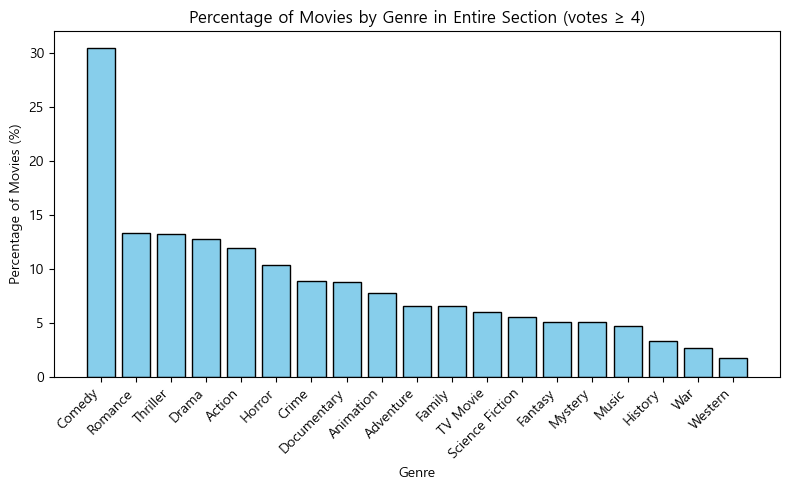

In [27]:
# 6. 시각화
plt.figure(figsize=(8,5))
plt.bar(genre_unique_counts["genre"], 
        genre_unique_counts["percentage_unique"], 
        color="skyblue", edgecolor="black")

plt.xticks(rotation=45, ha="right")
plt.title("Percentage of Movies by Genre in Entire Section (votes ≥ 4)")
plt.xlabel("Genre")
plt.ylabel("Percentage of Movies (%)")
plt.tight_layout()
plt.show()

In [28]:
'''
전체 구간을 기준으로 장르별로 비율을 확인 해 본 결과 코미디 장르가 30퍼센트로 가장많고 음악, 역사, 전쟁, 서부영화는 비율이 낮은걸 확인할 수 있다.

이제 평점을 기준으로 확인해본다면 위의 데이터와 비교하여 어떤 영화는 많이 만들어졌지만 평점이 낮은 영화가 많은 수 있고
어떤 영화는 많이 만들어지지는 않았지만 높은 평점의 영화가 많은 장르가 존재할 수 있음
다음 단계에서는 평점 별로 나누어 분석하여 효율을 분석한다.
'''

'\n전체 구간을 기준으로 장르별로 비율을 확인 해 본 결과 코미디 장르가 30퍼센트로 가장많고 음악, 역사, 전쟁, 서부영화는 비율이 낮은걸 확인할 수 있다.\n\n이제 평점을 기준으로 확인해본다면 위의 데이터와 비교하여 어떤 영화는 많이 만들어졌지만 평점이 낮은 영화가 많은 수 있고\n어떤 영화는 많이 만들어지지는 않았지만 높은 평점의 영화가 많은 장르가 존재할 수 있음\n다음 단계에서는 평점 별로 나누어 분석하여 효율을 분석한다.\n'

## 2. 전체구간 시대별 영화 장르 수 및 비율

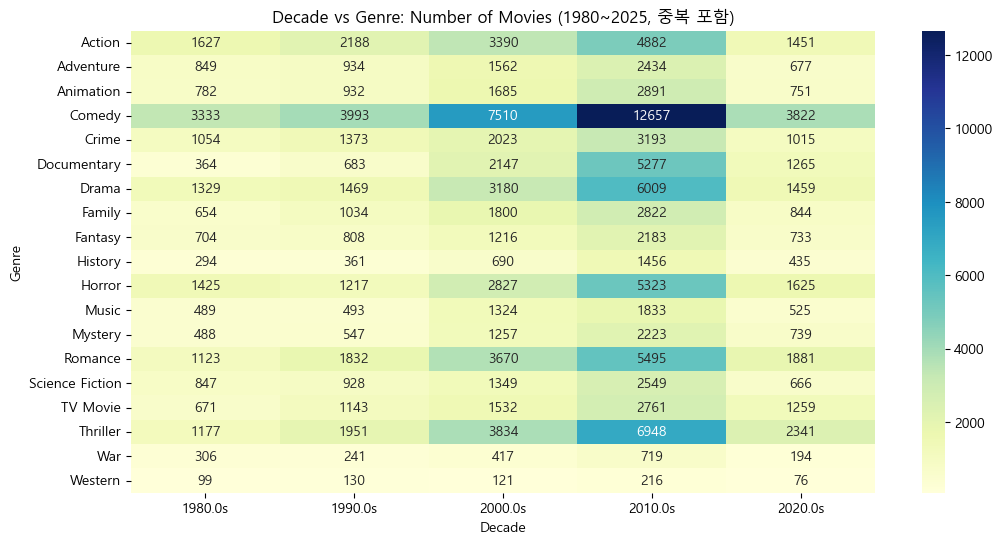

In [29]:
# 1) 연도 컬럼 만들기
df_genre_exp["year"] = pd.to_datetime(df_genre_exp["release_date"], errors="coerce").dt.year

# 2) 1980~2025 사이만 필터링
df_genre_exp = df_genre_exp[(df_genre_exp["year"] >= 1980) & (df_genre_exp["year"] <= 2025)]

# 3) Decade 컬럼 만들기
df_genre_exp["decade"] = (df_genre_exp["year"] // 10) * 10
df_genre_exp["decade"] = df_genre_exp["decade"].astype(str) + "s"

# 4) 시대별 × 장르별 영화 수 (중복 포함)
decade_genre_counts = (
    df_genre_exp.groupby(["decade", "genre"])["title"]
    .count()
    .reset_index(name="movie_count")
)

# 5) 피벗 테이블 변환
pivot_table = decade_genre_counts.pivot(index="genre", columns="decade", values="movie_count").fillna(0)

# 6) 시각화
import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Decade vs Genre: Number of Movies (1980~2025, 중복 포함)")
plt.ylabel("Genre")
plt.xlabel("Decade")
plt.show()

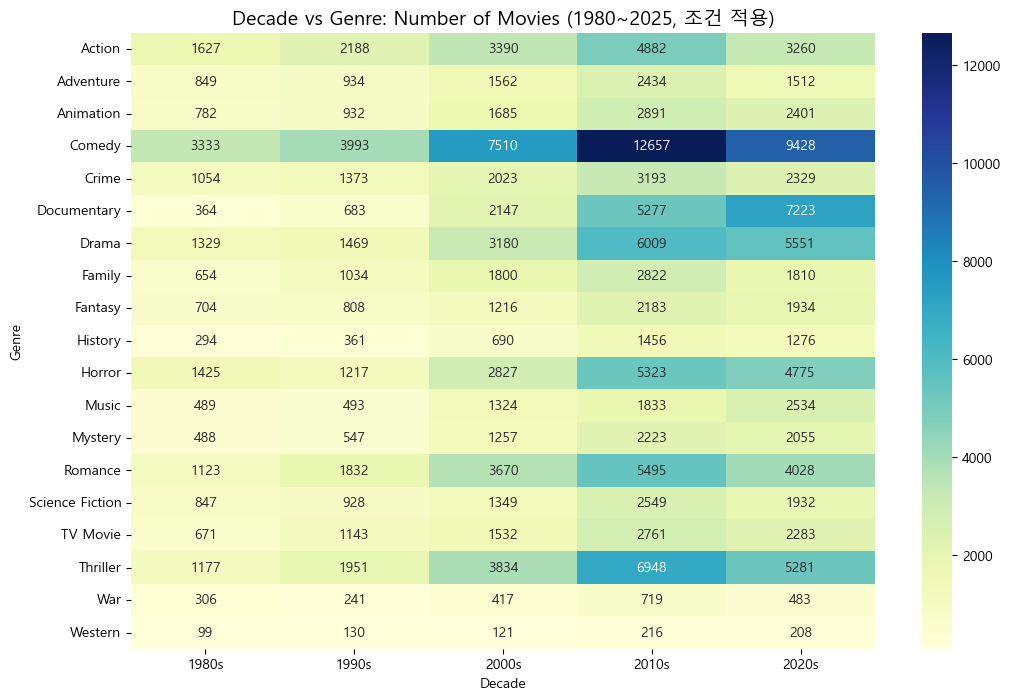

In [34]:
'''
위의 히트맵을 보면 과거부터 코미디 장르는 꾸준히 많이 만들어졌고 스릴러, 액션, 호러, 로맨스 영화가 많이 만들어졌음
다큐와 드라마는 다양한 장르와 결합되어서 제외된것이 있음에도 많은 것을 알 수 있음

하지만 이렇게 데이터를 확인했을때 2020년 이후의 영화 데이터는 최신화가 많이 되어있지 않아서 투표수가 많지않음
그래서 위와같은 조건으로 상위 퍼센트 기준 컷오프를 할 경우 1표이상이면 동일한 조건이 되어서
2020년 이후는 1표이상으로 컷오프를 하여 진행함
'''

# 1. release_date 변환
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# 2. 2020년대 (vote_count >= 1)
df_2020s = df[(df['release_date'].dt.year >= 2020) & (df['vote_count'] >= 1)]

# 3. 1980~2010년대 (vote_count >= 4)
df_1980_2010s = df[(df['release_date'].dt.year < 2020) & (df['vote_count'] >= 4)]

# 4. 합치기
df_combined = pd.concat([df_1980_2010s, df_2020s], ignore_index=True)

# 5. 장르 컬럼 정리 (explode용)
df_combined = df_combined.rename(columns={"genres_filtered": "genre"})
df_combined = df_combined.explode("genre")
df_combined = df_combined[
    df_combined["genre"].notna() & (df_combined["genre"].astype(str).str.strip() != "")
].copy()

# 6. 연도 → 시대(Decade) 변환
df_combined["decade"] = (df_combined["release_date"].dt.year // 10 * 10).astype(str) + "s"

# 7. 1980년대~2020년대 데이터만 필터
df_decade_filtered = df_combined[
    df_combined["release_date"].dt.year >= 1980
]
# 8. 집계
genre_decade_counts = (
    df_decade_filtered
    .groupby(["genre", "decade"])["title"]
    .count()
    .reset_index(name="movie_count")
)

# 9. 피벗 → 히트맵용
heatmap_data = genre_decade_counts.pivot(index="genre", columns="decade", values="movie_count").fillna(0)

# 10. 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Decade vs Genre: Number of Movies (1980~2025, 조건 적용)", fontsize=14)
plt.ylabel("Genre")
plt.xlabel("Decade")
plt.show()

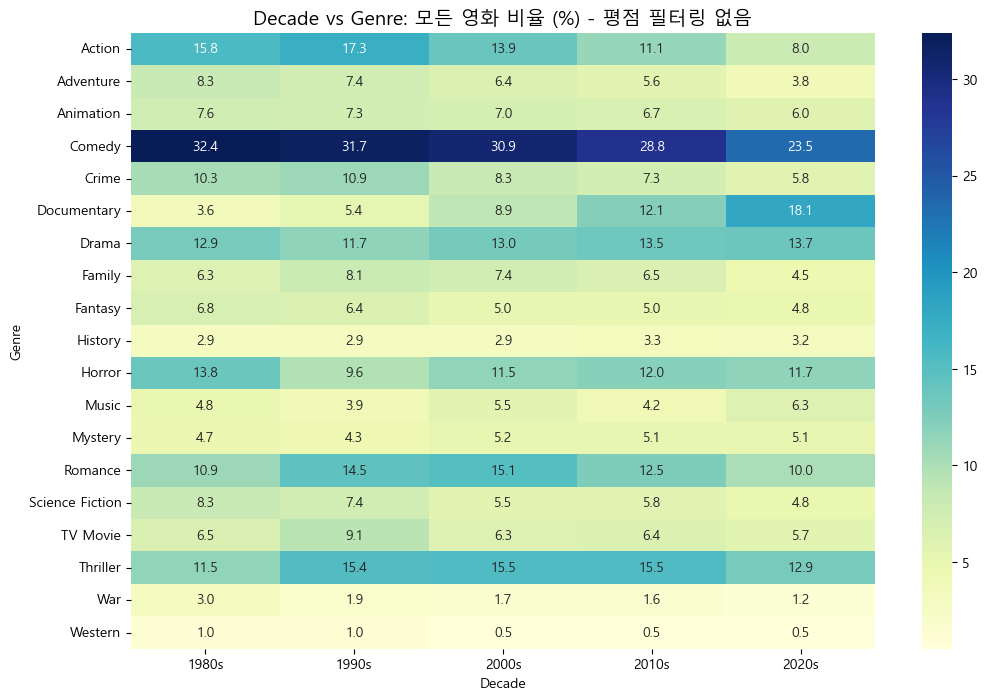

In [68]:
# 1) 시대별 × 장르별 고유 영화 수 계산
all_counts = (
    df_base.groupby(["genre", "decade"])["title"]
    .nunique()  # 고유 영화 수
    .reset_index(name="movie_count")
)

# 2) 각 시대별 전체 영화 수 계산
total_by_decade_all = (
    df_base.groupby("decade")["title"]
    .nunique()
    .to_dict()
)

# 3) 비율(%) 컬럼 추가
all_counts["percentage"] = all_counts.apply(
    lambda row: (row["movie_count"] / total_by_decade_all[row["decade"]]) * 100,
    axis=1
).round(1)

# 4) 피벗 테이블 변환 (히트맵용)
all_pivot = all_counts.pivot(index="genre", columns="decade", values="percentage").fillna(0)

# 5) 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(all_pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Decade vs Genre: 모든 영화 비율 (%) - 평점 필터링 없음", fontsize=14)
plt.ylabel("Genre")
plt.xlabel("Decade")
plt.show()

In [ ]:
'''
2020년대도 마찬가지로 코미디, 호러, 로맨스, 스릴러, 다큐, 드라마 장르가 강세를 보이고 있고 
현재 2025년이지만 이전시대보다 많은 영화가 제작되고 있음을 알 수 있다.

다음 단계는 이 데이터를 바탕으로 평점의 기준 중에서 '평범' 이상인 비율이 얼마인지 확인해보고
그다음 평범, 성공, 대성공을 나누어 어떤 장르가 꾸준한 성공을 했는가 또는 많은 작품에도 불구하고 성공의 비율이 적은가 등등
다양하게 살펴볼 것이다.
'''

## 2. 평점 6.5 이상 모든 구간 장르별 영화 수 및 비율

In [ ]:
'''
이번 단계에서는 평점 6.5점 이상인 모든 영화의 장르별 영화 수와 전체 대비 비율을 계산하여 '평범 이상'인 영화의 분포를 살펴봄.  
이후 평점을 세 구간으로 나누어 각 구간별 비율을 분석하고, 이를 바탕으로 시대별 흐름과 장르별 선호 경향을 예측함.
'''

In [40]:
# 1. 6.5점 이상 영화 필터링
df_high = df_genre_exp[df_genre_exp["vote_average"] >= 6.5].copy()

# 2. 장르별 고유 영화 수 계산
genre_high_counts = (
    df_high.groupby("genre")["title"].nunique().reset_index()
    .rename(columns={"title": "high_unique_count"})
)

# 3. 전체 영화 수 (고유 title 기준)
total_unique_movies = df_genre_exp["title"].nunique()

# 4. 전체 대비 비율 계산 (%)
genre_high_counts["percentage_overall"] = (
    genre_high_counts["high_unique_count"] / total_unique_movies * 100
).round(2)

# 5. 내림차순 정렬
genre_high_counts = genre_high_counts.sort_values(by="percentage_overall", ascending=False)


In [49]:
# =========================================
# 1) 전처리 유틸 함수들(한 번 정의해두고 계속 사용)
# =========================================
def parse_genres(val):
    """genres 컬럼을 '장르명 리스트' 형태로 변환함."""
    if isinstance(val, list):
        return [str(item.get("name", item)).strip() if isinstance(item, dict) else str(item).strip() for item in val]
    if isinstance(val, str):
        s = val.strip()
        if s in ("", "[]"):
            return []
        try:  # JSON 문자열 처리
            obj = json.loads(s.replace("'", '"'))
            if isinstance(obj, list):
                return [str(item.get("name", item)).strip() if isinstance(item, dict) else str(item).strip() for item in obj]
        except Exception:
            pass
        if "," in s:
            return [token.strip() for token in s.split(",") if token.strip()]
        return [s]
    return []

def filter_genres(genres_list):
    """드라마·다큐멘터리는 단일 장르일 때만 유지, 다른 장르와 함께 있을 경우 제거함."""
    exclude = ["Drama", "Documentary"]
    if not isinstance(genres_list, list):
        return []
    if len(genres_list) == 1:
        return genres_list
    return [g for g in genres_list if g not in exclude]

def ensure_datetime(df, col):
    """문자열 날짜를 datetime으로 변환하고, 변환 실패 시 NaT로 처리함."""
    df = df.copy()
    df[col] = pd.to_datetime(df[col], errors="coerce")
    return df

def clean_genre_column(df, src="genres_filtered", dst="genre"):
    """장르 컬럼을 explode하고, 결측/공백을 제거하여 단일 문자열로 통일함."""
    df = df.copy()
    if src != dst:
        df = df.rename(columns={src: dst})
    df = df.explode(dst)
    df = df[df[dst].notna() & (df[dst].astype(str).str.strip() != "")]
    df[dst] = df[dst].astype(str).str.strip()
    return df

def add_year_decade(df, date_col="release_date"):
    """연도(year)와 시대(decade: '1980s' 형식) 컬럼을 추가함."""
    df = df.copy()
    df["year"] = df[date_col].dt.year.astype("Int64")
    df = df[df["year"].notna()]
    df["year"] = df["year"].astype(int)
    df["decade"] = ((df["year"] // 10) * 10).astype(str) + "s"
    return df

def apply_vote_cut_rules(df):
    """투표수 컷 적용 (1980~2019: ≥4표, 2020~2025: ≥1표)."""
    early = df[(df["year"] < 2020) & (df["vote_count"] >= 4)]
    late  = df[(df["year"] >= 2020) & (df["vote_count"] >= 1)]
    return pd.concat([early, late], ignore_index=True)

def categorize_rating(v):
    """평점을 구간별로 분류."""
    if v >= 8.0:
        return "대성공"
    elif v >= 7.5:
        return "성공"
    elif v >= 6.5:
        return "평범"
    else:
        return "기타"

df_base["rating_category"] = df_base["vote_average"].apply(categorize_rating)

df_dt   = ensure_datetime(df, "release_date")

# (B) 장르 컬럼 통일 + explode
df_gen  = clean_genre_column(df_dt, src="genres_filtered", dst="genre")

# (C) 연/시대 컬럼 추가
df_gen  = add_year_decade(df_gen, date_col="release_date")

# (D) 분석 범위 필터(1980~2025) + 시대별 투표 컷 적용
df_gen  = df_gen[(df_gen["year"] >= 1980) & (df_gen["year"] <= 2025)]
df_base = apply_vote_cut_rules(df_gen)

###  2 - 1. 데이터 준비 및 시대별 x 장르별 영화 수 구하기

In [53]:
# 6.5점 이상만 필터링
df_high = df_base[df_base["vote_average"] >= 6.5].copy()

# 시대별 × 장르별 영화 수 계산
genre_decade_counts = (
    df_high.groupby(["decade", "genre"])["title"]
    .nunique()  # 고유 영화 수
    .reset_index(name="movie_count")
)

print(genre_decade_counts.head())

  decade      genre  movie_count
0  1980s     Action          411
1  1980s  Adventure          297
2  1980s  Animation          423
3  1980s     Comedy         1033
4  1980s      Crime          322


###  2 - 2. 각 시대별 비율(%) 계산

In [62]:
# 각 시대별 전체 영화 수
total_by_decade = (
    df_high.groupby("decade")["title"]
    .nunique()
    .reset_index(name="total_movies")
)

# 장르별 영화 수 데이터와 병합
genre_decade_counts = genre_decade_counts.merge(total_by_decade, on="decade", how="left")

   decade            genre  movie_count  total_movies_x  total_movies_y  total_movies  percentage
0   1980s           Action          411            3347            3347          3347       12.28
1   1980s        Adventure          297            3347            3347          3347        8.87
2   1980s        Animation          423            3347            3347          3347       12.64
3   1980s           Comedy         1033            3347            3347          3347       30.86
4   1980s            Crime          322            3347            3347          3347        9.62
..    ...              ...          ...             ...             ...           ...         ...
90  2020s  Science Fiction          991           22614           22614         22614        4.38
91  2020s         TV Movie         1176           22614           22614         22614        5.20
92  2020s         Thriller         2422           22614           22614         22614       10.71
93  2020s           

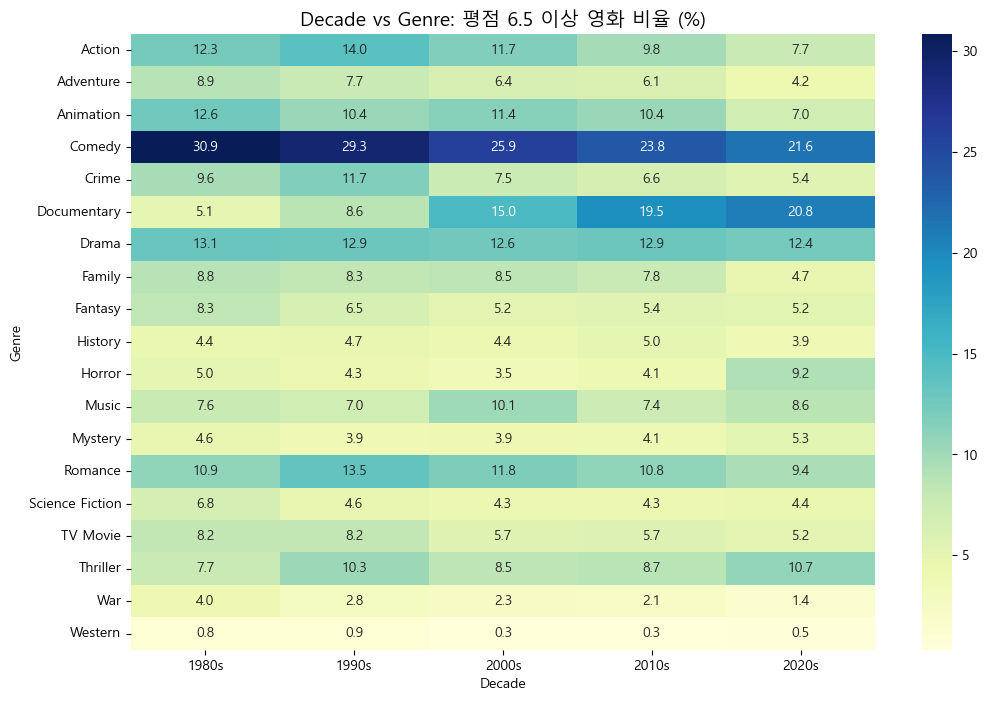

In [66]:
# 비율 계산 (%)
genre_decade_counts["percentage"] = (
    genre_decade_counts["movie_count"] / genre_decade_counts["total_movies"] * 100
).round(2)

# 피벗 변환 (행: 장르, 열: 시대, 값: 비율)
heatmap_data = genre_decade_counts.pivot(index="genre", columns="decade", values="percentage").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Decade vs Genre: 평점 6.5 이상 영화 비율 (%)", fontsize=14)
plt.ylabel("Genre")
plt.xlabel("Decade")
plt.show()

## 3. 평점 6.5 이상 7.5 이하 구간 장르별 영화 수 및 비율

In [74]:
# 6.5 ~ 7.5 평점 구간
# 시대별 × 장르별 영화 비율(%)

df_mid = df_base[
    (df_base["vote_average"] >= 6.5) &
    (df_base["vote_average"] < 7.5)
]

# 2) 시대별 × 장르별 고유 영화 수 계산
mid_counts = (
    df_mid.groupby(["genre", "decade"])["title"]
    .nunique()
    .reset_index(name="movie_count")
)

# 3) 각 시대별 전체 영화 수 계산 (이 구간 내에서)
total_by_decade_mid = (
    df_mid.groupby("decade")["title"]
    .nunique()
    .to_dict()
)

# 4) 비율(%) 컬럼 추가
mid_counts["percentage"] = mid_counts.apply(
    lambda row: (row["movie_count"] / total_by_decade_mid[row["decade"]]) * 100,
    axis=1
).round(1)

# 5) 피벗 테이블 변환
mid_pivot = mid_counts.pivot(index="genre", columns="decade", values="percentage").fillna(0)


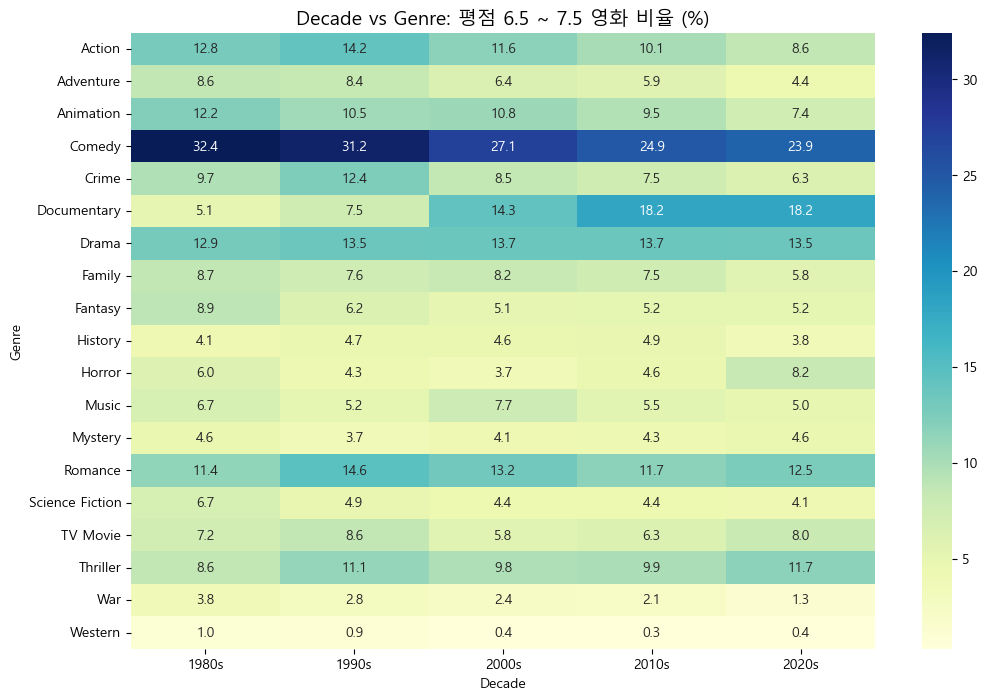

In [75]:
# 6) 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(mid_pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Decade vs Genre: 평점 6.5 ~ 7.5 영화 비율 (%)", fontsize=14)
plt.ylabel("Genre")
plt.xlabel("Decade")
plt.show()


## 4. 평점 7.5 이상 8.0 이하 구간 장르별 영화 수 및 비율

In [78]:
# 7.5 ~ 8.0 평점 구간
# 시대별 × 장르별 영화 비율(%)

df_high = df_base[
    (df_base["vote_average"] >= 7.5) &
    (df_base["vote_average"] < 8.0)
]

# 2) 시대별 × 장르별 고유 영화 수 계산
high_counts = (
    df_high.groupby(["genre", "decade"])["title"]
    .nunique()
    .reset_index(name="movie_count")
)

# 3) 각 시대별 전체 영화 수 계산 (이 구간 내에서)
total_by_decade_high = (
    df_high.groupby("decade")["title"]
    .nunique()
    .to_dict()
)

# 4) 비율(%) 컬럼 추가
high_counts["percentage"] = high_counts.apply(
    lambda row: (row["movie_count"] / total_by_decade_high[row["decade"]]) * 100,
    axis=1
).round(1)

# 5) 피벗 테이블 변환
high_pivot = high_counts.pivot(index="genre", columns="decade", values="percentage").fillna(0)


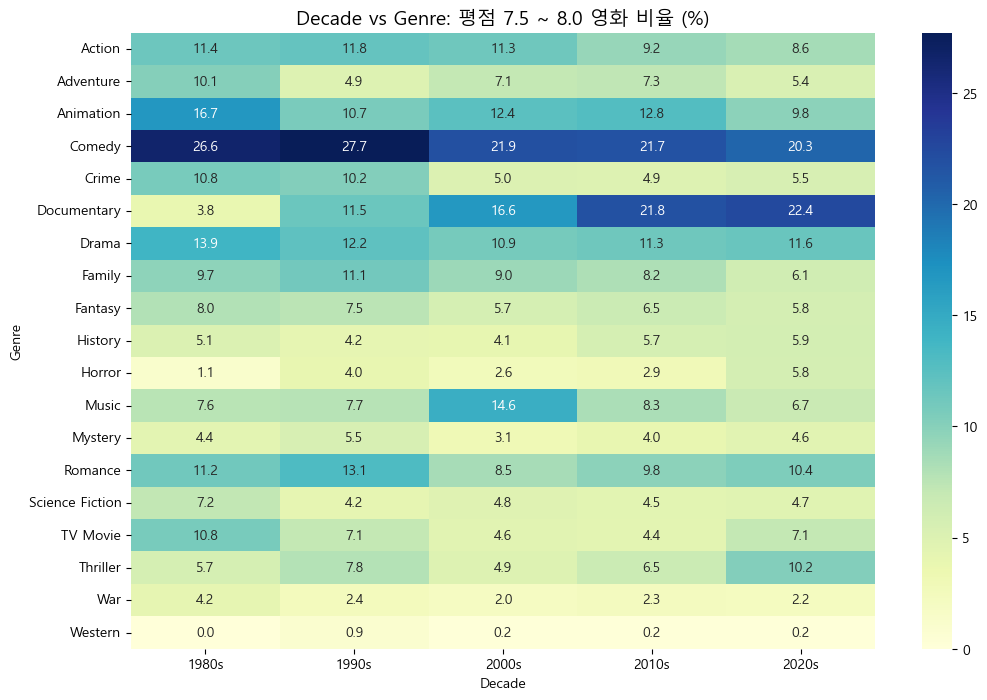

In [79]:
# 6) 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(high_pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Decade vs Genre: 평점 7.5 ~ 8.0 영화 비율 (%)", fontsize=14)
plt.ylabel("Genre")
plt.xlabel("Decade")
plt.show()

## 4. 평점 8.0 이상 구간 장르별 영화 수 및 비율

In [84]:
# 8.0 이상 평점 구간
# 시대별 × 장르별 영화 비율(%)

df_great_high = df_base[
    (df_base["vote_average"] >= 8.0)
]

# 2) 시대별 × 장르별 고유 영화 수 계산
great_high_counts = (
    df_great_high.groupby(["genre", "decade"])["title"]
    .nunique()
    .reset_index(name="movie_count")
)

# 3) 각 시대별 전체 영화 수 계산 (이 구간 내에서)
total_by_decade_great_high = (
    df_great_high.groupby("decade")["title"]
    .nunique()
    .to_dict()
)

# 4) 비율(%) 컬럼 추가
great_high_counts["percentage"] = great_high_counts.apply(
    lambda row: (row["movie_count"] / total_by_decade_great_high[row["decade"]]) * 100,
    axis=1
).round(1)

# 5) 피벗 테이블 변환
great_high_pivot = great_high_counts.pivot(index="genre", columns="decade", values="percentage").fillna(0)


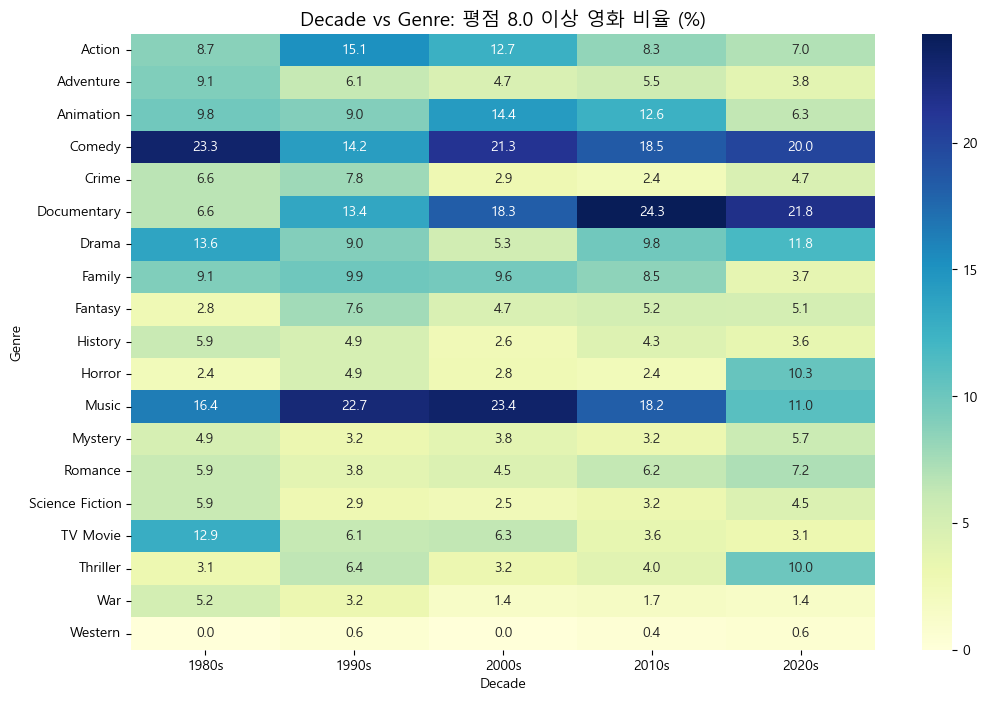

In [85]:
# 6) 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(great_high_pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Decade vs Genre: 평점 8.0 이상 영화 비율 (%)", fontsize=14)
plt.ylabel("Genre")
plt.xlabel("Decade")
plt.show()

## 5. 평점 구간 별 비율 분석

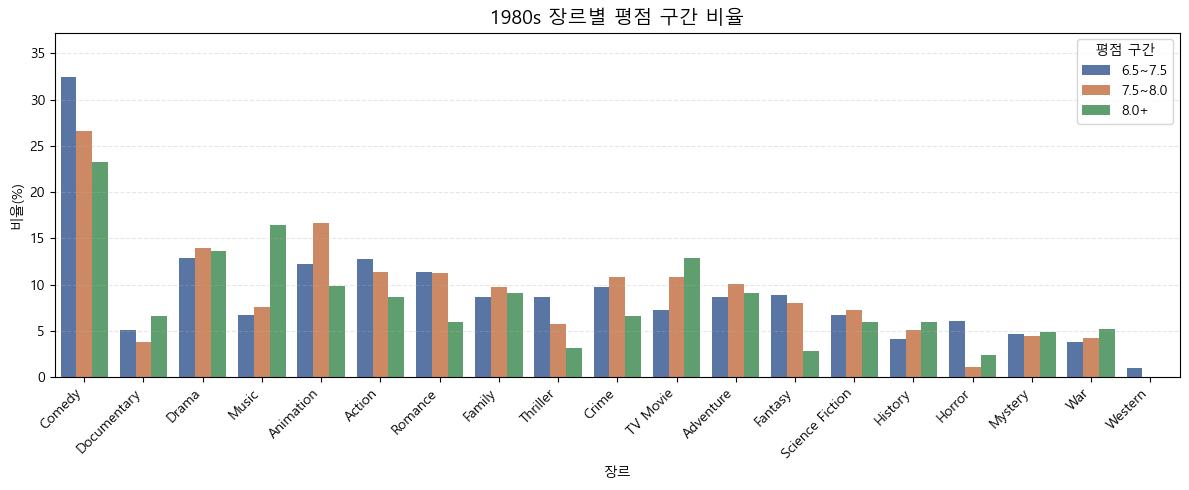

<Figure size 640x480 with 0 Axes>

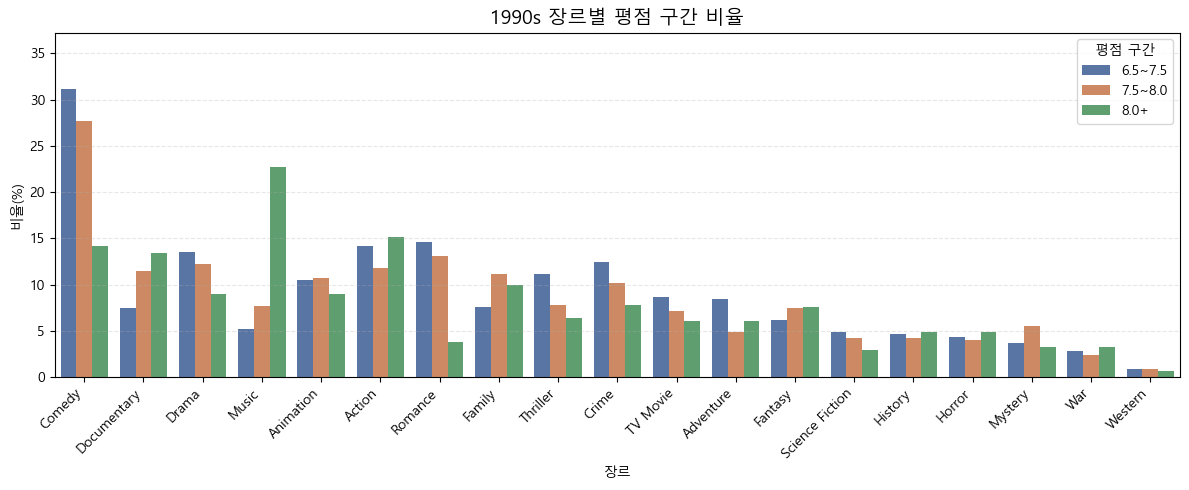

<Figure size 640x480 with 0 Axes>

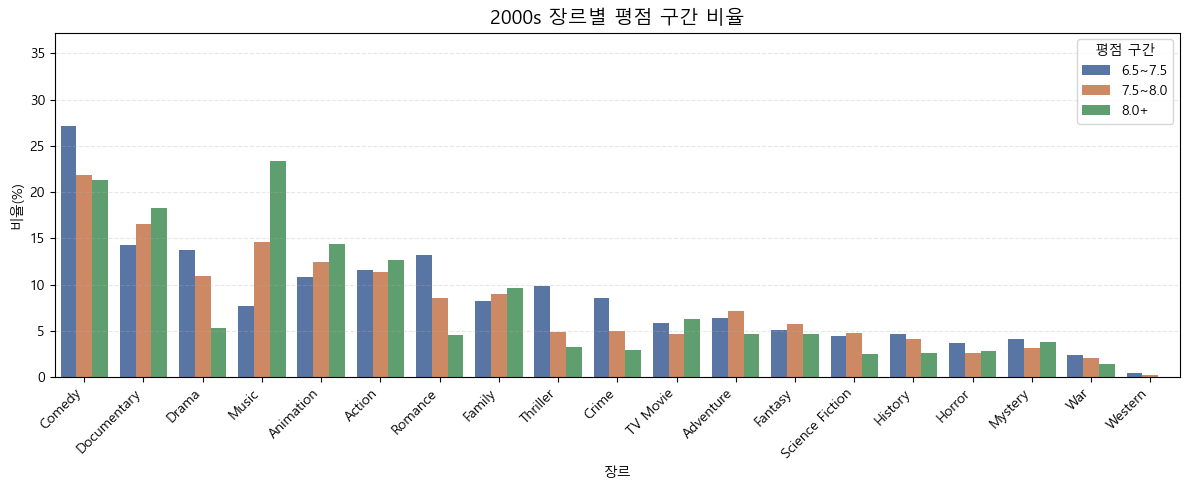

<Figure size 640x480 with 0 Axes>

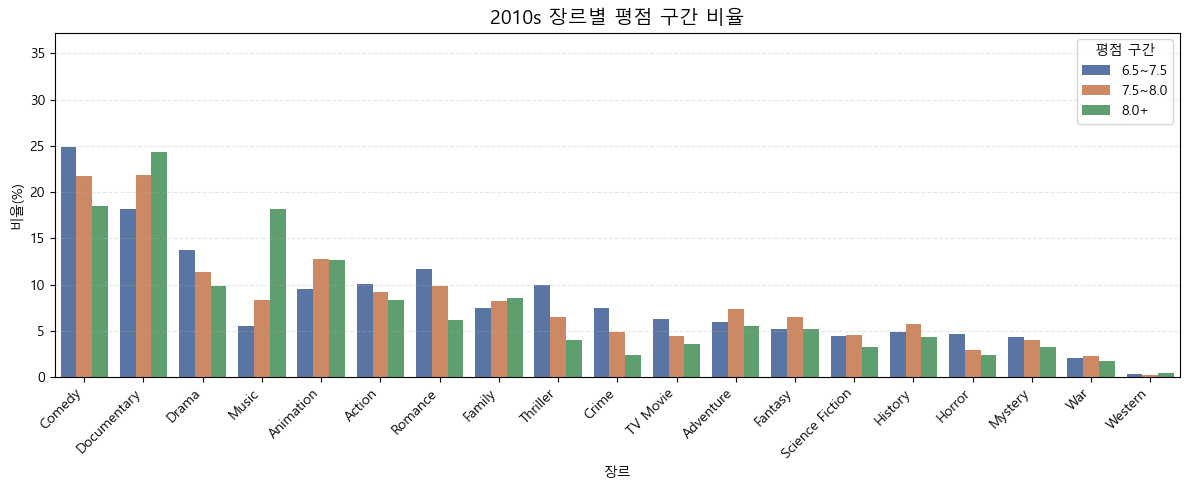

<Figure size 640x480 with 0 Axes>

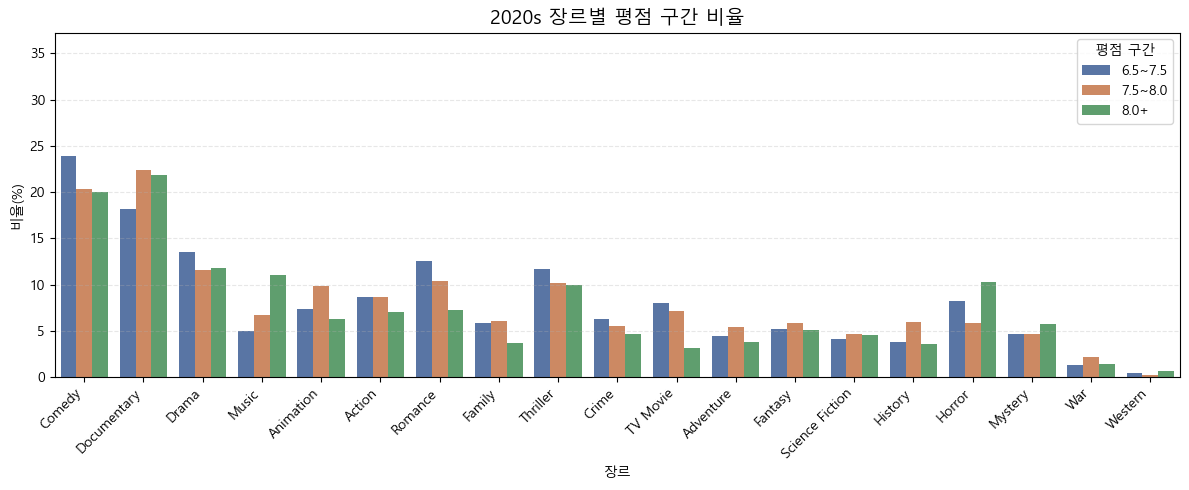

<Figure size 640x480 with 0 Axes>

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 0) 공통 설정: 장르 정렬 고정 + 전 범위의 y축 최대값(비교용)
# ---------------------------------------------------
# - 전체 평균 비율 기준으로 장르 순서를 고정함
genre_order = (
    df_all_decade.groupby("genre", observed=True)["percentage"]
    .mean().sort_values(ascending=False).index.tolist()
)
df_all_decade["genre"] = pd.Categorical(df_all_decade["genre"], categories=genre_order, ordered=True)

# - 모든 시대를 같은 스케일로 비교하고 싶다면 아래 최대값을 사용함
global_ymax = df_all_decade["percentage"].max() * 1.15

# - 색상 팔레트 고정
palette = ["#4C72B0", "#DD8452", "#55A868"]

# - 그릴 decade 목록
decades = sorted(df_all_decade["decade"].unique())

# ---------------------------------------------------
# 1) 시대별 개별 그래프(세로 막대) — 각 figure로 따로 출력
# ---------------------------------------------------
for dec in decades:
    # 해당 시대 데이터만 선택함
    data_d = df_all_decade[df_all_decade["decade"] == dec].copy()

    plt.figure(figsize=(12, 5))
    sns.barplot(
        data=data_d,
        x="genre", y="percentage",
        hue="rating_range",
        errorbar=None, dodge=True, palette=palette
    )
    plt.title(f"{dec} 장르별 평점 구간 비율", fontsize=14)
    plt.xlabel("장르"); plt.ylabel("비율(%)")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, global_ymax)             # ✅ 모든 시대를 같은 스케일로 보고 싶다면 유지
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.legend(title="평점 구간", loc="upper right")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"decade_{dec}_bar.png", dpi=200)   # ← 파일 저장을 원하면 주석 해제

# 분석 결과

In [ ]:
'''
1. 전체적 장르 분포 특징
 1.1 코미디
  - 모든 시대와 평점 구간에서 높은 비중 유지
  - 1980년대 부터 높은 점유율을 유지하다가 시대가 지날수록 점유율이 조금씩 하락

 1.2 드라마
  - 모든 구간에서 안정적으로 중상위 비율 유지
  - 평점 구간이 올라가도 비율 변화가 크지 않음 -> 평점과의 상관성은 중립적임
  
 1.3 다큐멘터리
  - 저평점 구간에서는 비중이 낮지만 8.0+ 구간에서 급상승
  - 장르 특성상 소수 작품이지만 평균 평점이 높은 경향이 반영됨
  
 1.4 뮤직
  - 전체 비중은 작지만 8.0+ 구간에서 높은 경향을 보임
  
 1.5 애니메이션
  - 6.5 ~ 7.5 구간에서 많이 보이며 애니메이션은 7.5이상에서도 일정 비율을 유지하는 고평점 작품 비율이 높은 장르
  
 1.6 액션
  - 모든 시대에서 작품 수 자체는 많은편
  - 6.5 ~ 7.5 구간에서는 결과가 나쁘지않지만 8.0+ 구간 비중이 현저히 낮음
  - 원인은 블록버스터 중심으로 시각적 재미는 있지만 스토리, 작품성은 낮은것으로 추정
  
 1.7 판타지
  - 전 시대적으로 8.0+ 구간의 비중이 낮고 7.5 ~ 8.0 구간에서도 중하위권
  - 높은 제작비에 비해 작품성 유지가 어렵고 특정 시리즈물에 편중되어 있어 실패작이 평균을 많이 깎는 것으로 추정
  
 1.8 호러
  - 고평점 비율이 매우 낮음
  - 호불호가 극명하고 저예산, 양산형 작품이 많아 비평가와 관객 모두에 평균 평점이 낮게 나오는 구조

 1.9 로맨스
  - 6.5 ~ 7.5 구간에 집중됨
  - 8.0+ 구간은 거의없는 시대도 존재
  - 감성 장르 특성상 장르 팬층에게는 사랑받지만 그 외에는 평점이 좋지 않은 것으로 추정

2. 시대별 변화 흐름
 2.1 1980s
  - 코미디와 드라마 비율이 절대적
  - 액션, 애니메이션 비율도 높은편
  - 8.0+ 구간에서 뮤직 장르가 강세를 보임

 2.2 1990s
  - 여전히 코미디 우세, 그러나 다큐멘터리와 뮤직의 고평점 구간 비율이 상승하고 애니메이션의 고평점 비율이 뚜렷하게 나타남.

 2.3 2000s
  - 다큐멘터리의 8.0+ 비율이 크게 증가
  - 코미디의 비율이 전반적으로 감소
  - 액션, 애니메이션이 7.5이상 구간 안정적 비율이 유지

 2.4 2010s
  - 다큐멘터리, 뮤직의 고평점 비중이 최고수준
  - 장르 다양성이 가장 확대되어 다양한 장르가 나타난 시기

 2.5 2020s
  - 전체적으로 비율이 고르게 분포
  - 다큐멘터리와 뮤직은 여전히 고평점 비율이 높고, 액션과 코미디 비율이 과거 대비 더 낮아짐

 2.6 하락 현상
  - 2000s 이후 코미디, 액션, 판타지 등 대중장르가 고평점 비중에서 점진적 하락

3. 평점 구간별 패턴
 3.1 6.5 ~ 7.5 구간
  - 시장에서 대중적 상업영화가 몰려있는 구간
  - 코미디, 드라마, 액션 중심의 비율이 있고 장르 편중이 심함.

 3.2 7.5 ~ 8.0 구간
  - 장르 다양성 증가
  - 다큐멘터리, 뮤직, 애니메이션 비율 증가
  - 코미디, 드라마는 여전히 강세지만 비중이 점점 줄어듬

 3.3 8.0+ 구간
  - 다큐멘터리, 뮤직장르가 최상위 비중 -> 작품수는 적지만 높은 평점의 경향
  - 코미디는 상위권에 남아있지만, 6.5 ~ 7.5 구간에 비해서는 감소
  - 액션, 판타지 등 블록버스터 장르는 고평점 비율이 낮음

4. 종합 인사이트
 4.1 장르별 평점
  - 다큐멘터리, 뮤직 -> 작품 수는 적지만 고평점의 비중이 높음(전문성, 예술성 강점)
  - 코미디, 드라마 -> 모든 평점 구간에 고르게 존재하며 안정적인 소비층
  - 액션, 판타지, 스릴러 -> 고평점의 비율은 낮음, 대중성은 높으나 평가 편차가 큼

 4.2 시대적 장르 변화
  - 1980 ~ 2000년대 초반은 코미디와 드라마중심으로 특정 장르가 집중됨
  - 2010년대 이후는 장르가 다양화되고 뮤직과 다큐멘터리등 고평점장르가 부상함

 4.3 전략적 시사점
  - 고평점, 작품성 중심 : 다큐멘터리, 뮤직, 애니메이션
   -> 작품 수는 적어도 고평점 비중이 높음
   -> 영화제, 비평가 중심의 주목을 받기 쉬움
   
  - 대중성, 흥행 중심 : 코미디, 드라마, 액션
   -> 관객수나 작품 수는 많지만 평점 효율은 낮음
   -> 흥행 중심 전략에 유리하지만, 작품성 개선의 여지가 큼

  - 위험부담 장르 : 호러, 판타지, 스릴러, 로맨스
   -> 실패 시 평균 평점 하락이 큼
   -> 기획, 제작 퀄리티 편차 관리가 중요함
   
  - 시대별 트렌드 분석을 통해 영화 제작을 원하는 방향으로 최적화 가능



| 장르       | 작품 수 | 고평점(8.0+) 비중 | 평가                      |
| ---------- | ------ | ---------------- | ------------------------- |
| 다큐멘터리 | 적음   | 매우 높음        | 작품성 중심 강세           |
| 뮤직       | 적음   | 매우 높음        | 예술성·전문성 인정          |
| 애니메이션 | 보통   | 높음             | 안정적 품질 유지           |
| 코미디     | 많음   | 중간             | 대중성 강점, 고평점 효율 낮음 |
| 드라마     | 많음   | 중간             | 안정적                     |
| 액션       | 많음   | 낮음             | 흥행은 강하지만 작품성 약세   |
| 판타지     | 보통   | 낮음             | 편차 큼, 실패작 영향 큼      |
| 스릴러     | 보통   | 낮음             | 평점 안정성 부족           |
| 호러       | 보통   | 매우 낮음        | 호불호 강함, 저예산 문제    |
| 로맨스     | 보통   | 낮음             | 감성 편중, 비평 약세        |
'''